# PROJET D'ANALYSE DE DONNEES DU VENDEE GLOBE
### Vincent Bardonnet - Telecom Paris - 30/11/2020
Les analyses sur les graphiques qui suivent ont donc été effectués pendant le déroulement de la course, les bateaux n'ayant pas encore dépassé le Cap de Bonne-Espérance.
Néanmoins le programme fait en sorte de se mettre à jour pour récupérer les rapports du vendée globe les plus récents.

## Librairies spéciales à télécharger

pip install ipyleaflet

# Import des librairies
## Note importante
Il existe un fichier python nommé "downloader.py" qui doit être placé dans le même dossier que ce ".ipynb". Il contient diverses fonctions de téléchargement en parallèle et de nettoyage de données.

In [1]:
# coding: utf-8
from downloader import *
import os
import re
import unittest
import requests
from six.moves import urllib
import multiprocessing as mp
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from math import cos,sqrt
import matplotlib.pyplot as plt
from collections import Counter 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from geopy.distance import geodesic

from ipyleaflet import Map, AntPath, basemaps, Marker,basemap_to_tiles,LayersControl,LayerGroup,Polyline
from ipywidgets import HTML

pd.set_option('display.max_rows', 300)

# Récupération des fichiers Excel avec les classements

Uniquement les rapports excels du vendée globe non présent dans le dossier sont téléchargés et en parallèle.

In [2]:
def files_getter(url):
    all_files = []
    r = requests.get(url)
    html = BeautifulSoup(r.content.decode('utf-8'),'html.parser')
    for info in html.find('select',{'class','form__input m--select onsubmit-rank'}).findAll('option'):
        if info.attrs.get('value') != "":
            all_files.append(info.attrs.get('value'))
    return all_files

In [3]:
all_files = files_getter("https://www.vendeeglobe.org/fr/classement")
all_files = all_files[:-1] #On enlève le dernier car vide (avant départ)

In [4]:
if not os.path.exists("downloaded_files\\"):
    os.makedirs("downloaded_files\\")
download = mp.Pool().map(files_downloader, all_files)

# Extraction des fiches techniques pour chacun des voiliers.

In [5]:
if 'caracteristiques.xlsx' not in os.listdir('downloaded_files\\'):
    caracteristiques_downloader() #Dans downloader.py

# Rapprochement des caractéristiques des voiliers avec celle des classements.

In [6]:
merging_files = os.listdir('downloaded_files\\')
combined = pd.DataFrame()
combined = combined.append(mp.Pool().map(merger, merging_files)) #CLASSEMENTS

In [7]:
caract = pd.read_excel('downloaded_files\\caracteristiques.xlsx', encoding='utf-8',decimal=',')
caract.rename(columns={'Unnamed: 0': 'nom'}, inplace=True)
caract.nom = caract.nom.str.title()
caract = caract.replace('Arnaud Boissières','Arnaud Boissieres') # è dans glossaire
caract = caract.replace('Sam Davies','Samantha Davies') #Samantha est réduit à "Sam" dans le glossaire
caract = caract.replace('Alan  Roura','Alan Roura') #Il y a "deux espaces" entre Alan et Mourra dans le html du glossaire des bateaux

In [8]:
#database avec RET
db = combined.merge(caract)
db.rang = db.rang.astype(int)

# Visualisation de la distance à la ligne d'arrivée, par voilier

Sur le graphe ci-dessous, les labels sont classés de haut en bas du premier au dernier.
On voit que Jérémie Beyou a eu un problème dans la journée du 10 Novembre ce qui l'a obligé à retourner au départ. Mais ce dernier semble avoir comblé très rapidement sont retard vers le 28 novembre environ. Par soucis de précision, uniquement le dernier rapport de chaque journée est récupéré.
On voit ainsi que la courbe descends parfois notamment dans la journée du 27 novembre, cela veut dire que les skipper ont entammés une manoeuvre qui les ont éloignés de l'arrivé.

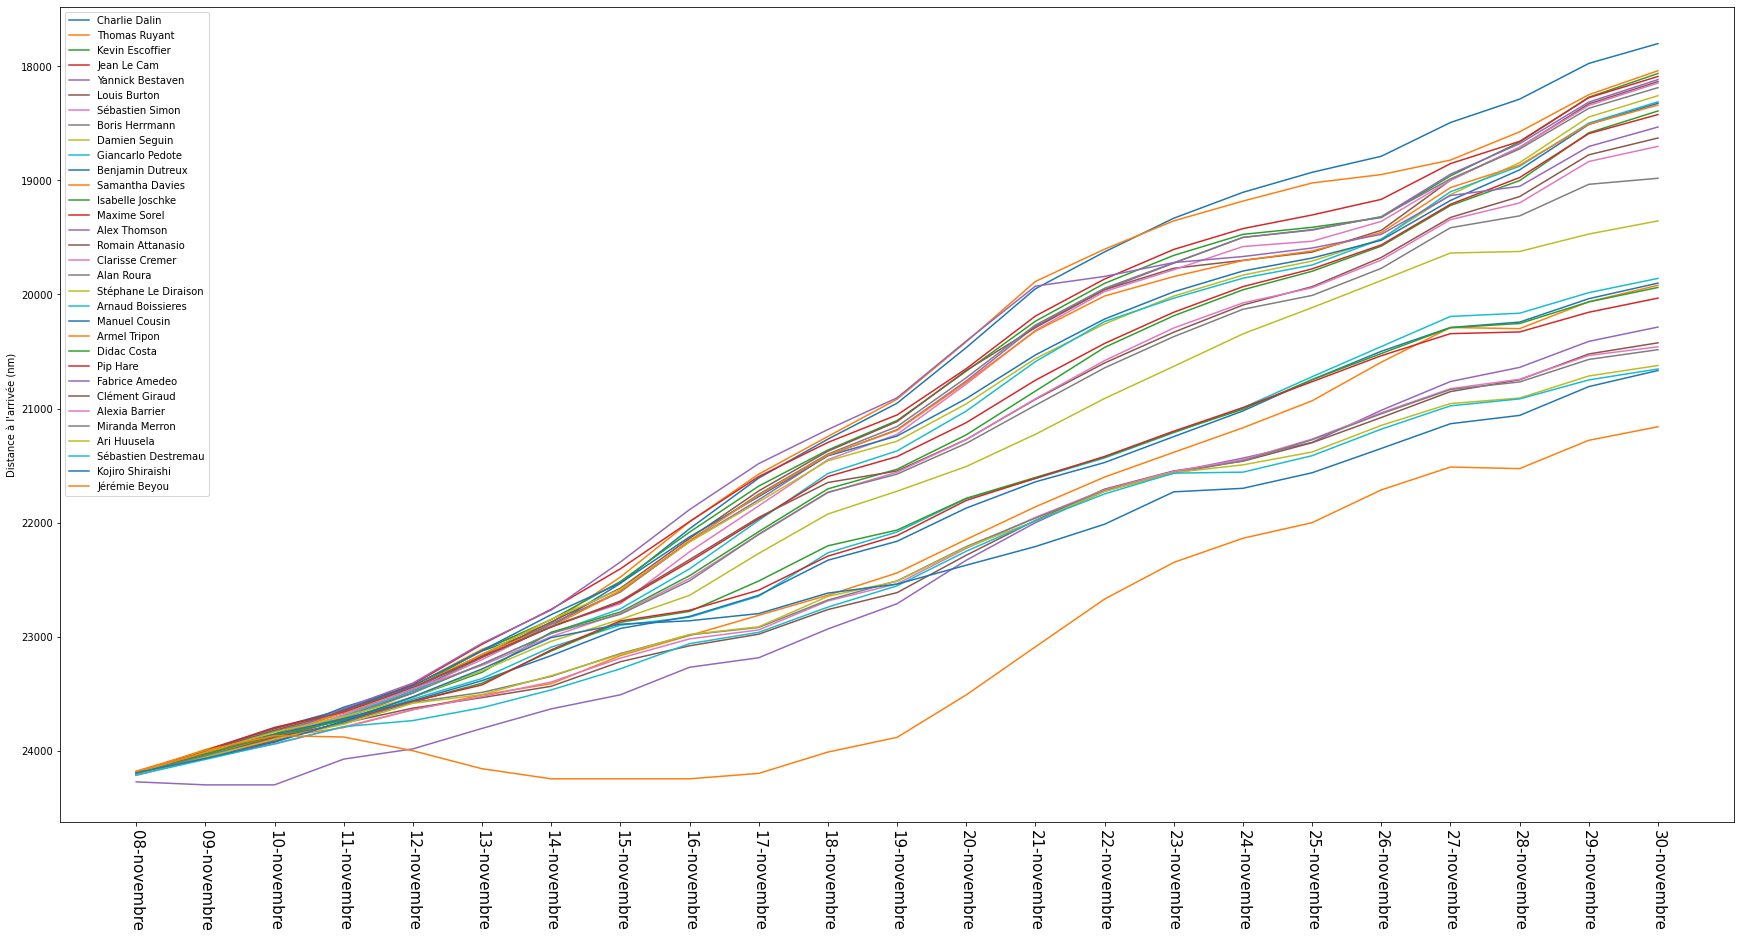

In [9]:
fig, ax = plt.subplots(figsize=(30,15))
ref_jour = db.drop_duplicates(subset="nom", keep="last").sort_values(by='rang')['jour'].values[-1]
ref_mois = db.drop_duplicates(subset="nom", keep="last").sort_values(by='rang')['mois'].values[-1]
list_ingame = []
for name in db.drop_duplicates(subset="nom", keep="last").sort_values(by='rang').nom.values:
    sub_db = db.loc[db.nom == name].drop_duplicates(subset="jour", keep="last")
    jour = sub_db['jour'].drop_duplicates().values[-1]
    mois = sub_db['mois'].drop_duplicates().values[-1]
    if (jour == ref_jour) and (mois == ref_mois):
        list_ingame.append(name)
        plt.plot(sub_db["jour"]+"-"+sub_db["mois"],sub_db["dtf"],label=name)

#     print(sub_db[['jour','distParcourue']])
plt.xticks(fontsize = 15 , rotation=-90)
plt.ylabel("Distance à l'arrivée (nm)")
ax.invert_yaxis()
plt.legend()
plt.show()

N'étant pas moi-même familier avec la navigation maritime, il s'agirait donc de savoir si ce choix d'éloignement par rapport à l'arrivée est un choix stratégique sur le long terme où s'il s'agit simplement d'une erreur, auquel cas un suivi en temps réel de ce paramètre permettrait à un skipper de corriger sa trajectoire avec une meilleure rigourisité.

# Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
# +
# Impact de la présence d'un *foil* sur le classement et la vitesse des voiliers.

In [10]:
db['vitMean'] = db.iloc[:, [10,14,18]].astype(float).mean(axis=1) #Moyenne des Vitesses(30min,24heure,Last_report)

A partir de la moyenne des vitesses enregistrées à 3 instants différents et calculée précédemment sous le nom "vitMean",
un premier graphique (ci-dessous) permet d'apercevoir une légère disparité dans les groupes formés par les bateaux ayant des "foils" et ceux n'ayant que "2" dérives. 

Les foils (en bleu) ayant tendance à être plus haut dans le classement avec une vitesse moyenne plus grande (haut-droit du graphique).

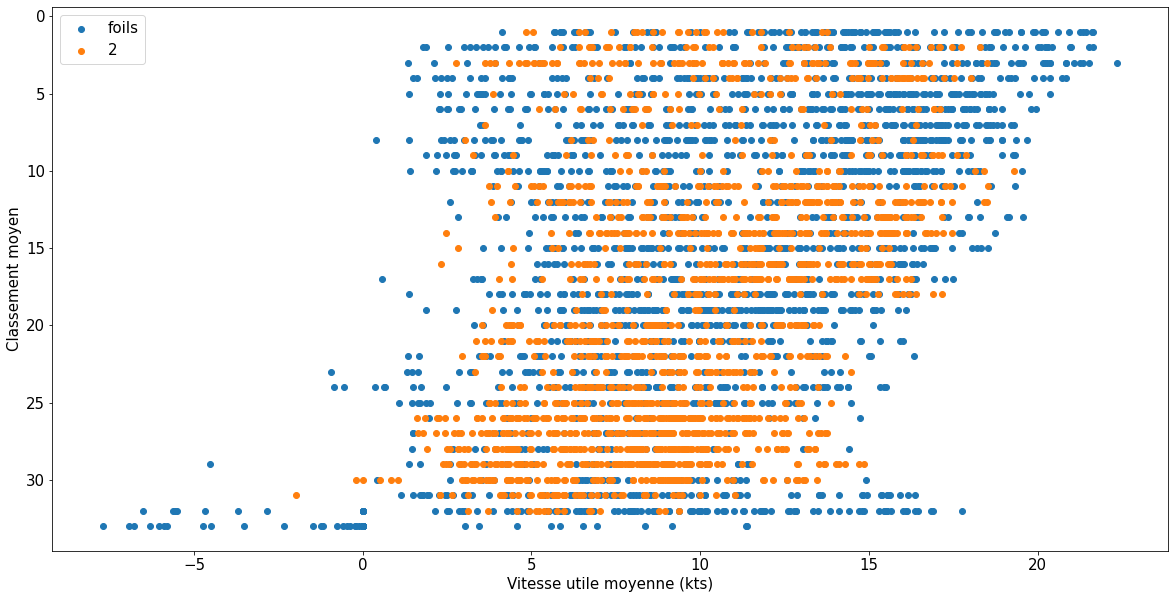

In [11]:
x = db.vitMean[db.derive == 'foils'].astype(float)
y = db.rang[db.derive == 'foils'].astype(int)
X1, Y1 = [], []
for x,y in sorted(zip(x,y), key = lambda A: A[0]):
    X1.append(x)
    Y1.append(y)

x = db.vitMean[db.derive == '2'].astype(float)
y = db.rang[db.derive == '2'].astype(int)
X2, Y2 = [], []
for x,y in sorted(zip(x,y), key = lambda A: A[0]):
    X2.append(x)
    Y2.append(y)

fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(X1,Y1,label = 'foils')
plt.scatter(X2,Y2,label = '2')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.invert_yaxis()
plt.xlabel('Vitesse utile moyenne (kts)', fontsize = '15')
plt.ylabel('Classement moyen', fontsize = '15')
plt.legend(prop={'size': 15})
plt.show()

Suivant cette logique : "le plus rapide sera le premier", nous pouvons effectuer la moyenne sur le rang et la vitesse de chaque skipper pour voir si cette corrélation aussi forte existe.

In [12]:
#Mean Speed and mean Rank dataframe
mean_db = pd.DataFrame()
list_noms = db.drop_duplicates(subset="nom", keep="last").sort_values(by='rang').nom.values
for name in list_noms:
    meanSpeed = db.vitMean.astype(float).loc[db.nom == name].mean()
    meanRank = db.rang.astype(int).loc[db.nom == name].mean()
    derive = db.derive.loc[db.nom == name].tolist()[0]
    mean_db = mean_db.append({'meanRank':meanRank,'nom':name, 'meanSpeed':meanSpeed, 'derive':derive}, ignore_index=True)

### Corrélation Rang et Vitesse moyens

In [13]:
mean_db.corr(method='pearson')

,meanRank,meanSpeed
meanRank,1.000000,-0.922727
meanSpeed,-0.922727,1.000000


Nous constatons qu'il y a bien une correlation très forte entre le rang et la vitesse utile (VMG) des bateaux.

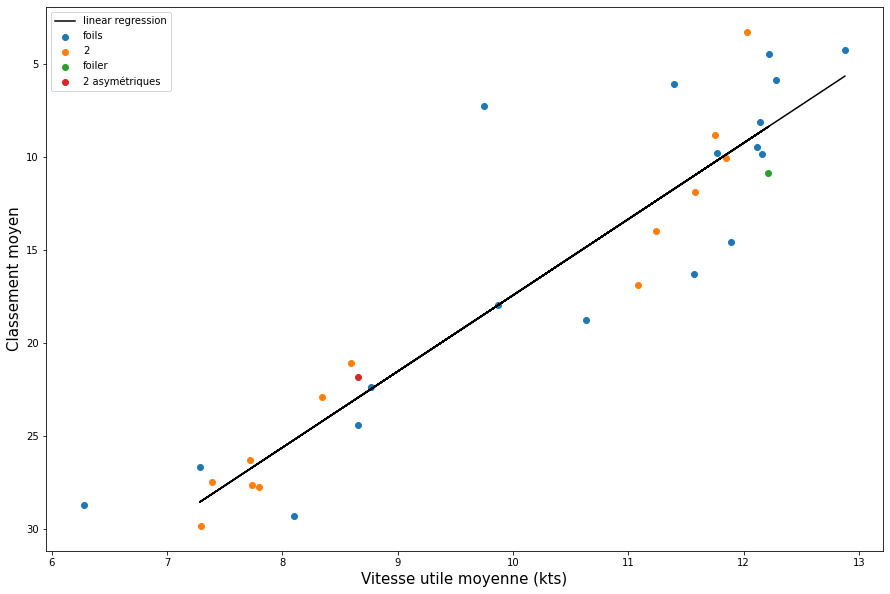

In [14]:
list_eliminated = list((Counter(list_noms)-Counter(list_ingame)).elements()) 

fig, ax = plt.subplots(figsize=(15,10))

for derive in mean_db.derive.drop_duplicates().values.tolist():
    x = mean_db.meanSpeed.loc[mean_db.derive==derive]
    y = mean_db.meanRank.loc[mean_db.derive==derive]
    ax.scatter(x,y,label=derive)

#Linear Regression
list_x = mean_db.meanSpeed.values.reshape(-1, 1)
list_y = mean_db.meanRank.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(list_x,list_y,test_size=1/3,random_state=0)
regressor = LinearRegression()
regressor.fit(X_train,y_train)
plt.plot(X_train, regressor.predict(X_train), color='black',label='linear regression')

ax.invert_yaxis()
plt.xlabel('Vitesse utile moyenne (kts)',fontsize='15')
plt.ylabel('Classement moyen',fontsize='15')
plt.legend()
plt.show()

L'on peut ainsi voir que la vitesse moyenne influe sur le classement des skippers et que de plus, les bateaux avec des "foils" possèdent une vitesse moyenne plus importante (points bleus).
On remarque tout de même un bateau avec 2 dérives en au du classement, il s'agit de celui de Jean Le Cam qui en moyenne est en haut du classement. On peut émettre l'hypothèse qu'il y a un __paramètre non quantifiable__ rentrant en compte, il s'agit de __l'expérience__ du skipper.

# Visualisation de la distance parcourue par voilier

* Uniquement les skippers encore en course sont affichés
* __distance parcourue__(km) = SOMME(distance_depuis_dernier_rapport)*1.852 

Le graphe de bars suivant est intéressant car il montre en quelque sorte l'efficacité des skippers, c'est à dire leur ration "classement"/"distance parcourue".
Par exemple, Didac Costa a effectué au 29/11/2020 (20:00) environ 500 km de moins que Amel Tripon cepandant il est à ce moment devant lui.

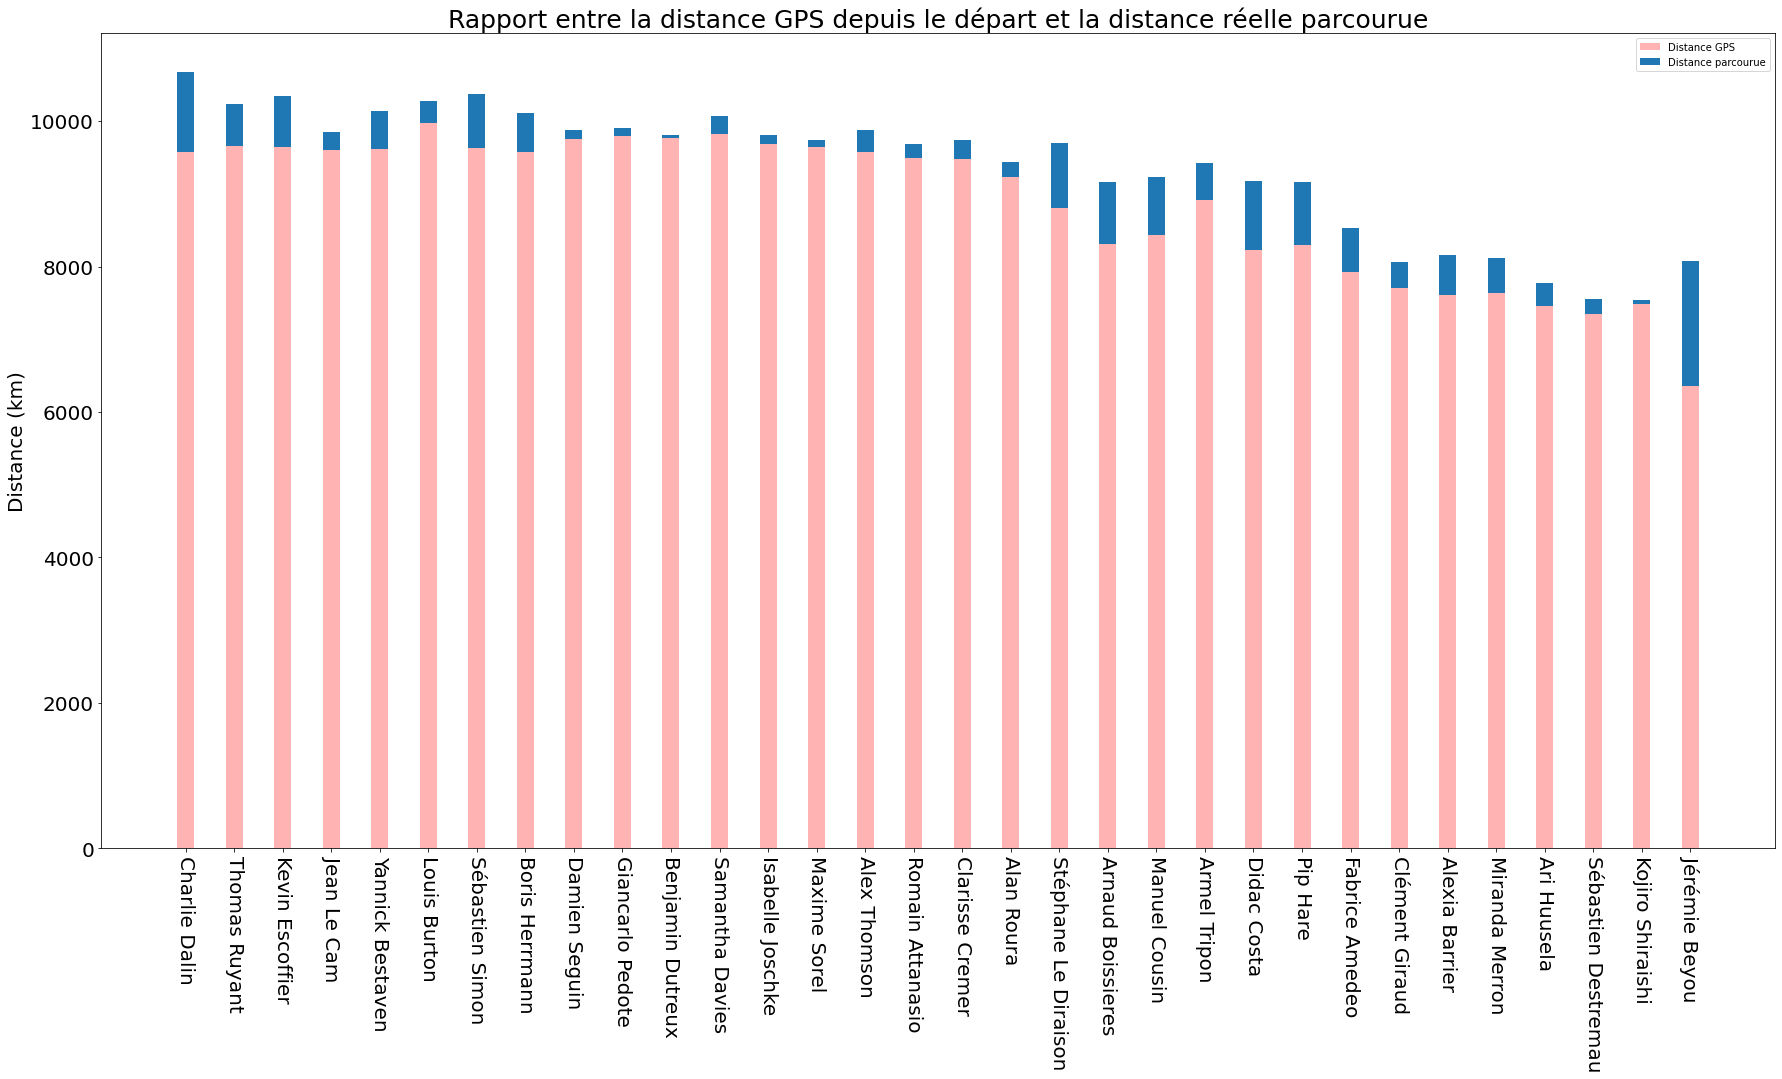

In [15]:
fig, ax = plt.subplots(figsize=(30,15))
dist_tot = db.drop_duplicates(subset="nom", keep="first").dtf[:-2].mean()
list_dist_prat = []
list_dist_theo = []

for name in db.drop_duplicates(subset="nom", keep="last").sort_values(by='rang').nom.values:
    sub_db = db.loc[db.nom == name]
    jour = sub_db['jour'].drop_duplicates().values[-1]
    mois = sub_db['mois'].drop_duplicates().values[-1]
    if (jour == ref_jour) and (mois == ref_mois):
        #distance Pratique
        list_dist_prat.append(sub_db.distLast.values.sum())
        #distance Théorique
        coord1 = sub_db.loc[(sub_db.jour=='08') & (sub_db.mois=='novembre')][['lat','lon']].values[0]
        coord2 = sub_db.loc[(sub_db.jour==jour) & (sub_db.mois==mois)][['lat','lon']].values[-1]
        coords_1 = (coord1[0], coord1[1])
        coords_2 = (coord2[0], coord2[1])
        dist_theo = round(geodesic(coords_1, coords_2).km,2)
        list_dist_theo.append(dist_theo)
        
ind = np.arange(len(list_ingame))        
p1 = plt.bar(ind, list_dist_theo, width = 0.35, color = '#ffb3b3')
p2 = plt.bar(ind, [x1 - x2 for (x1, x2) in zip(list_dist_prat, list_dist_theo)], width = 0.35,bottom=list_dist_theo)
plt.xticks(ind,list_ingame,fontsize = 20 , rotation=-90)
plt.yticks(fontsize = 20)
plt.ylabel("Distance (km)",fontsize = 20)
plt.legend((p1[0], p2[0]), ('Distance GPS', 'Distance parcourue'))
plt.title('Rapport entre la distance GPS depuis le départ et la distance réelle parcourue',fontsize=25)
plt.show()

Jérimie Béyou ayant du retourner au point de départ il est celui qui a parcouru la plus grande distance comme le montre la bar rose.

On peut souligner le fait que dans la tête du classement se trouve __Jean Le Cam__ (29/11/2020), le seul parmis des bateaux a "foils" que nous savons très rapides en moyenne grâce à l'analyse précédente. On remarque qu'il a un __ratio bar rose / bar bleu__ très élevé qui témoigne de son efficacité. 

# Map Monde des Positions
### Par soucis de fonctionnement, une map à jour du 30/11/2020 au format HTML a été ajouté au préalable dans le dossier du projet.

In [16]:
list_color = ['#ffb3b3','#ffc6b3','#ccff66','#ffd9b3','#ffecb3','#ffffb3','#ecffb3','#d9ffb3','#c6ffb3','#b3ffb3','#b3ffc6','#b3ffec','#ffffff','#b3ffff','#b3ecff','#b3d9ff','#b3c6ff','#b3b3ff','#c6b3ff','#d9b3ff','#ecb3ff','#ffb3ff','#ffb3ec','#ffb3d9','#ffb3c6','#ffb3b3','#ffcc00','#cc9900','#996633','#999966','#99ff33','#ffff99','#669999']

Je ne sais pourquoi mais le méthode "Group_layer" n'ajoute que le dernier skipper du classement, par conséquent j'ai choisi d'ajouter le "chemin" et le "marker" de chaque skipper indépendemment ce qui fait que les "chemins" seulement peuvent être décochés. 

In [17]:
ref_jour = db.drop_duplicates(subset="nom", keep="last").sort_values(by='rang')['jour'].values[-1]
ref_mois = db.drop_duplicates(subset="nom", keep="last").sort_values(by='rang')['mois'].values[-1]
list_marker = []
list_path = []
m = Map(basemap=basemap_to_tiles(basemaps.Esri.WorldImagery),zoom=2)

for name,color in zip(list_noms,list_color):
    
    jour = db.loc[db.nom == name,['jour']].values[-1][0]
    mois = db.loc[db.nom == name,['mois']].values[-1][0]
    heure = db.loc[db.nom == name,['heure']].values[-1][0]
    rang = db.loc[db.nom == name,['rang']].values[-1][0]
    derive = db.loc[db.nom == name,['derive']].values[-1][0]
    lat = db.loc[db.nom == name,['lat']].values[-1][0]
    lon = db.loc[db.nom == name,['lon']].values[-1][0]
    location = []
    
    #Les joueurs encore en course
    if (jour == ref_jour) and (mois == ref_mois):
        location=db.loc[db.nom == name,['lat','lon']].values.tolist()
        ant_path = AntPath(name=str(str(rang)+" : "+name),locations=location,dash_array=[1, 10],delay=1000,color=color,pulse_color=color,weight=3)

        message = HTML(value="name: %s derive: %s  "%(name,derive))
        marker = Marker(name=str(str(rang)+" : "+name),location=(lat, lon),draggable=False)
        marker.popup = message
        list_marker.append(marker)
        list_path.append(ant_path)
        # Layer Group ne fonctionne pas
        #  layer_group = LayerGroup(layers=(ant_path,marker))
        #  m.add_layer(layer_group)
        
        m.add_layer(marker)
        m.add_layer(ant_path)
    
    #Les joueurs ayant abandonnés
    else:
        lat = db.loc[db.nom == name,['lat']].values[0][0]
        lon = db.loc[db.nom == name,['lon']].values[0][0]
        message = HTML(value="name: %s derive: %s  "%(name,derive))
        derive = db.loc[db.nom == name,['derive']].values[-1][0]
        marker = Marker(name=str("RET : "+name),location=(lat, lon),draggable=False)
        marker.popup = message
        m.add_layer(marker)

control = LayersControl(position='topright')
m.add_control(control)

m.save("Map_Monde_VendéeGlobe.html", title = "Map_Monde_VendéeGlobe")
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# Conclusion Générale

On a pu voir que le vendée globe est un projet très intéressant qui m'a permis à titre personnel de prendre connaissance de l'importance de l'organisation d'un code, de l'acquisition à l'utilisation des données en passant par le formatage. On a pu voir aussi des fonctionnalités très intéressantes comme ipealyflet (pour la Map) et différentes méthodes de représentation de la donnée par les graphiques.

Je pense tout de même que d'autres analyses auraient pu être faites en utilisant des techniques de Machine Learning par exemple mais il me faudrait plus de temps pour investiguer celles-ci.

Finalement, il s'agit d'un projet qui à la fin de la course sera très volumineux, le Dataframe nommé __"db"__ notamment. Mon remord par rapport à cela est de ne pas avoir pensé dès le début à implémenter le module __pickle__ pour le partitionnage de celui-ci. Malheureusement les 10 jours alloués pour ce projet et un emploi du temps chargé m'ont pris au dépourvu. 